# Final processing and statistical analysis of preprocessed and validated data.

In [1]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
from ua_parser import user_agent_parser
from geolite2 import geolite2
import geopandas as gpd
import pycountry
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
print(sns.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.8)      
#sns.set_palette('autumn')

def read_db_config(filename='config-dump.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)
 
    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))
 
    return db

dbconfig = read_db_config()
CONN = 'mysql+mysqlconnector://'+dbconfig['user']+':'+dbconfig['pwd']+'@'+dbconfig['host']+':'+dbconfig['port'] + '/'+dbconfig['dbname']
engine = create_engine(CONN)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

0.9.0


## 1. Outlier report (using raw data)

In [2]:
# Load data of all participants 
P_QUERY = "SELECT * FROM PARTICIPANTS" 
p_all = pd.read_sql_query(P_QUERY, engine)
p_all.fillna(0, inplace=True)
p_all[p_all.AGE!=0].AGE.describe()

count   49630.000
mean       24.972
std        18.076
min         1.000
25%        18.000
50%        23.000
75%        29.000
max      3015.000
Name: AGE, dtype: float64

In [3]:
numrows = len(p_all)

print(f"Number of raw records in PARTICIPANTS: {len(p_all)}")

mask = (p_all.WPM <= 0) | (p_all.WPM >= 200)
print(f"WPM outliers: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.ERROR_RATE < 0) | (p_all.ERROR_RATE >= 25)
print(f"ERROR_RATE outliers: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.IP_ADDRESS == 0)
print(f"IP_ADDRESS zero: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.FINGERS == 'undefined;undefined') | (p_all.FINGERS == 'false') | (p_all.FINGERS == 'other')
print(f"FINGERS undefined: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.DEVICE == 0) 
print(f"DEVICE zero: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.DEVICE == 'desktop') 
print(f"DEVICE = desktop: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )


Number of raw records in PARTICIPANTS: 274178
WPM outliers: 208918 (76.20%)
ERROR_RATE outliers: 1878 (0.68%)
IP_ADDRESS zero: 13139 (4.79%)
FINGERS undefined: 282 (0.10%)
DEVICE zero: 13635 (4.97%)
DEVICE = desktop: 12053 (4.40%)


## 2. Data cleaning and feature parsing

In [10]:
# Load data of valid participants 
P_QUERY = "SELECT * FROM VALID_PARTICIPANTS_OLD" 
participants = pd.read_sql_query(P_QUERY, engine)
participants.fillna(0, inplace=True)
participants.rename(columns={'BROWSER': 'UA'}, inplace=True)

In [11]:
def parse_fingers_usage():
    # Parsing reported hands and fingers
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'right_hand;thumbs' if x =='1 hand thumb' else x)
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'right_hand;index_fingers' if x =='1 hand pointer' else x)
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'both_hands;thumbs' if x =='2 hands thumbs' else x)
    participants[['HAND','FINGER','NUM_FINGERS']] = participants['FINGERS'].str.split(';',expand=True)
    participants.fillna('0', inplace=True)

    # If number of fingers reported
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: str(x).strip().lower())
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'17', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'all', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'10', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'ten', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 8 if bool(re.search(r'8', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 8 if bool(re.search(r'eight', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 6 if bool(re.search(r'6', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 6 if bool(re.search(r'six', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 5 if bool(re.search(r'5', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 5 if bool(re.search(r'five', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'4', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'Four', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'2 on both', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'(thumbs|fingers).*(thumbs|fingers)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 3 if bool(re.search(r'3', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 3 if bool(re.search(r'three', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'2', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'two', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'both', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(thumb|index).*(index|thumb)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(thumb|middle).*(middle|thumb)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(index|middle).*(middle|index)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(middle|ring).*(ring|middle)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(pinky|middle).*(middle|pinky)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thumbs', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thums', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thombs', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'and', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thumb,index', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'one', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'index', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'middle', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'thumb', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if str(x) == '1' else x) 
    
    # If no number of fingers reported, calculate it from selected HAND and FINGERS options
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'both_hands'), 'NUM_FINGERS'] = 2
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'left_hand'), 'NUM_FINGERS'] = 1
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'right_hand'), 'NUM_FINGERS'] = 1
    
    participants['NUM_FINGERS'] = pd.to_numeric(participants['NUM_FINGERS'], errors='coerce')

def parse_advanced_input():
    # Parsing reported features 
    participants['REP_F_SWIPE'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'swipe', x))))
    participants['REP_F_PREDICTION'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'prediction', x))))
    participants['REP_F_AUTOCORRECTION'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'autocorrection', x))))
    participants['REP_F_OTHER'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'other', x))))
    participants['REP_F_NO'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'"no"', x))))
    participants['REP_F_NOTSURE'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'notsure', x))))
    

def parse_keyboard_app():
    # Parsing reported keyboard app
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: x.strip())
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Kika' if bool(re.search(r'kik', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Emoji' if bool(re.search(r'Emjoi', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Cheetah' if bool(re.search(r'Cheet', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Fleksy' if bool(re.search(r'Flesky', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Minuum' if bool(re.search(r'Minimum', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Blackberry' if bool(re.search(r'Blackberry', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Grammarly' if bool(re.search(r'Gramme', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Ridmik' if bool(re.search(r'Ridmik', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Facemoji' if bool(re.search(r'Facemoji', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'FancyKey' if bool(re.search(r'Fanc', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Facemoji' if bool(re.search(r'Face emoji', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Go' if bool(re.search(r'Go keyb', x, re.IGNORECASE)) else x) 

def parse_user_agent():
    ### Parsing User Agent string
    participants['BROWSER'] = participants.UA.apply(lambda x:  user_agent_parser.ParseUserAgent(x)['family'])
    participants['OS'] = participants.UA.apply(lambda x:  user_agent_parser.ParseOS(x)['family'])
    participants['D_FAMILY'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['family'])
    participants['D_BRAND'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['brand'])
    participants['D_MODEL'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['model'])

In [12]:
parse_fingers_usage()
parse_advanced_input()
parse_keyboard_app()
parse_user_agent()

# Time spent typing - convert to numeric 
participants['TIME_SPENT_TYPING'] = pd.to_numeric(participants.TIME_SPENT_TYPING, errors='coerce')

participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 

# Type English == '' in case of native==English, set it to 'native'
participants['TYPE_ENGLISH'] = participants.TYPE_ENGLISH.apply(lambda x: 'native' if x== '' else x)

mask = (participants.WPM <= 0) | (participants.WPM >= 200)
print("Removed as WPM outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.ERROR_RATE < 0) | (participants.ERROR_RATE >= 25)
print("Removed as ERROR_RATE outliers: ", len(participants[mask]))
participants = participants[~mask]

# Not available for anonymized data
#mask = (participants.IP_ADDRESS == 0)
#print("Removed as IP_ADDRESS outliers: ", len(participants[mask]))
#participants = participants[~mask]

mask = (participants.FINGERS == 'undefined;undefined') | (participants.FINGERS == 'false') | (participants.FINGERS == 'other')
print("Removed as FINGERS undefined: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.DEVICE == 0) 
print("Removed as DEVICE zero: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.DEVICE == 'desktop') 
print("Removed as DEVICE = desktop: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.HAND == 'undefined') | (participants.FINGER == 'undefined') | (participants.FINGER == 'false')
print("Removed as HAND / FINGERS undefined: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.TIME_SPENT_TYPING > 24) | (participants.TIME_SPENT_TYPING < 0)
print("Removed as TIME_SPENT_TYPING invalid: ", len(participants[mask]))
participants = participants[~mask]

Removed as WPM outliers:  0
Removed as ERROR_RATE outliers:  0
Removed as IP_ADDRESS outliers:  0
Removed as FINGERS undefined:  176
Removed as DEVICE zero:  0
Removed as DEVICE = desktop:  0
Removed as HAND / FINGERS undefined:  52
Removed as TIME_SPENT_TYPING invalid:  8


## 3. Demographics of participants

### 3.1 Mapping of reported native languages and detected countries (not available for anonymized data)

In [13]:
def get_country_iso(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['iso_code'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

geo = geolite2.reader()

unique_ips = participants.IP_ADDRESS.unique()
unique_ips = pd.Series(unique_ips, index = unique_ips)
participants['DET_COUNTRY'] = participants.IP_ADDRESS.map(unique_ips.apply(get_country_iso))

geolite2.close()

Text(0.5,1,'Number of participants mapped by detected country')

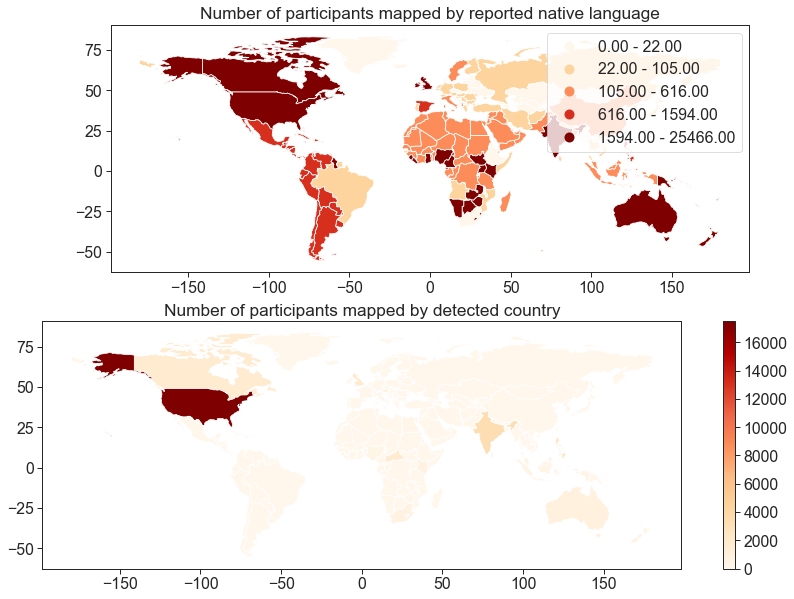

In [14]:
# World map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['iso_a2']=world['iso_a3'].apply(lambda x: x[:2])

# Dataframe for mapping country code and language
# http://download.geonames.org/export/dump/countryInfo.txt
geonames = pd.read_csv('data/geonames.txt', sep='\t', usecols=['ISO3', 'Country', 'Languages'])
geonames.dropna(inplace=True, axis=0)
geonames['lang'] = geonames['Languages'].apply(lambda x: re.split('[,-]', x)[0])

# Merge two dataframes above by country code
langmap1 = pd.merge(world, geonames[['ISO3', 'lang']], how='inner', left_on=['iso_a3'], right_on=['ISO3']).fillna(0, downcast='infer')
# Count and map participants by NATIVE_LANGUAGE
lang_native = participants.NATIVE_LANGUAGE.value_counts().to_frame()
lang_native.reset_index(inplace=True)
lang_native.rename(columns={'index':'lang', 'NATIVE_LANGUAGE': 'lang_native_cnt'}, inplace=True)
#lang_native['log_lang_native_cnt'] = lang_native.lang_native_cnt.apply(lambda x: np.log(x)) 
langmap1 = pd.merge(langmap1, lang_native, how='left', on='lang')
langmap1.fillna(0, inplace=True, downcast='infer')

# Count and map participants by DET_COUNTRY
det_country = participants.DET_COUNTRY.value_counts().to_frame()
det_country.reset_index(inplace=True)
det_country.rename(columns={'index':'iso_a2', 'DET_COUNTRY': 'det_country_cnt'}, inplace=True)
#det_country['log_det_country_cnt'] = det_country.det_country_cnt.apply(lambda x: np.log(x)) 
langmap2 = pd.merge(world, det_country, how='left', on='iso_a2')
langmap2.fillna(0, inplace=True, downcast='infer')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
langmap1.plot(column='lang_native_cnt', cmap='OrRd', scheme='quantiles', ax=axs[0], legend = True);
axs[0].set_title('Number of participants mapped by reported native language')
langmap2.plot(column='det_country_cnt', cmap='OrRd',  ax=axs[1], legend = True);
axs[1].set_title('Number of participants mapped by detected country')

### 3.2 Encoding age categories

In [15]:
from pandas.api.types import is_numeric_dtype
def categorize_age(x):
    
    if x > 0 and x < 10:
        return '0-9'
    elif x >= 10 and x < 20:
        return '10-19'
    elif x >= 20 and x < 30:
        return '20-29'
    elif x >= 30 and x < 40:
        return '30-39'
    elif x >= 40 and x < 50:
        return '40-49'
    elif x >= 50 and x < 60:
        return '50-59'
    elif x >= 60 and x < 70:
        return '60-69'
    elif x >= 70 and x < 80:
        return '70-79'
    elif x >= 80 and x < 90:
        return '80-89'
    elif x >= 90 and x < 100:
        return '90-99'
    else:
        return '100+'
    
participants['AGE_CAT'] = participants['AGE'].apply(lambda x: categorize_age(x)) 

### 3.3 Creating U.S. subsample (not available for anonymized data)

In [17]:
# Male 49.4%, female 50.6%  (https://countrymeters.info/en/United_States_of_America_(USA))

# Age structure: 0-14 years: 18.73% (male 31,255,995/female 29,919,938)
# 15-24 years: 13.27% (male 22,213,952/female 21,137,826)
# 25-54 years: 39.45% (male 64,528,673/female 64,334,499)
# 55-64 years: 12.91% (male 20,357,880/female 21,821,976)
# 65 years and over: 15.63% (male 22,678,235/female 28,376,817) (2017 est.) (https://www.indexmundi.com/united_states/age_structure.html)
    
# Age median: males: 36.8, females: 39.4
# Age under 15: 20.1%, 15-64: 66.8%, >65: 13% (https://countrymeters.info/en/United_States_of_America_(USA)#age_structure)
# Android 54.1%, iOS 44.5% (https://www.statista.com/statistics/266572/market-share-held-by-smartphone-platforms-in-the-united-states/)

In [19]:
def categorize_age_2(x):   
    if x > 0 and x < 14:
        return '0-14'
    elif x >= 15 and x < 24:
        return '15-24'
    elif x >= 25 and x < 54:
        return '25-54'
    elif x >= 55 and x < 64:
        return '55-64'
    else:
        return '65+'
    
participants['AGE_CAT_2'] = participants['AGE'].apply(lambda x: categorize_age_2(x)) 

In [20]:
age_0_14_US = participants[(participants.DET_COUNTRY=='US') & (participants.AGE_CAT_2=='0-14')].sample(frac=0.686249)
age_15_24_US = participants[(participants.DET_COUNTRY=='US') & (participants.AGE_CAT_2=='15-24')].sample(frac=0.0936848542)
age_25_54_US = participants[(participants.DET_COUNTRY=='US') & (participants.AGE_CAT_2=='25-54')].sample(frac=0.285947240)
age_55_US = participants[(participants.DET_COUNTRY=='US') & (participants.AGE_CAT_2.isin(['55-64','65+']))]#.sample(frac=0.416655)

participants_US = pd.concat([age_0_14_US, age_15_24_US, age_25_54_US, age_55_US], axis=0)

female_US = participants_US[(participants_US.DET_COUNTRY=='US') & (participants_US.GENDER=='female')].sample(frac=0.332)
male_US = participants_US[(participants_US.DET_COUNTRY=='US') & (participants_US.GENDER=='male')]
participants_US = pd.concat([female_US, male_US], axis=0)

ios_US = participants_US[ (participants_US.OS=='iOS')].sample(frac=0.41)
andr_US = participants_US[(participants_US.OS=='Android')]
participants_US = pd.concat([ios_US, andr_US], axis=0)

### 3.4 TOP-N aggregates

In [22]:
N = 5

# Countries
country = participants_US.DET_COUNTRY.value_counts(normalize=True).reset_index()[:N]

# Native NATIVE_LANGUAGE
native = participants_US.NATIVE_LANGUAGE.value_counts(normalize=True).reset_index()[:N]

# Genders
gender = participants_US.GENDER.value_counts(normalize=True).reset_index()[:N]

# English typing
type_eng = participants_US.TYPE_ENGLISH.value_counts(normalize=True).reset_index()[:N]

demogr_summary = pd.concat([gender, country, native, type_eng], axis=1)
demogr_summary.columns = ['GENDER', 'GENDER %', 'DET_COUNTRY', 'DET_COUNTRY %','NATIVE_LANGUAGE', 'NATIVE_LANGUAGE %', 'TYPE_ENGLISH', 'TYPE_ENGLISH %']
demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_ENGLISH %']] = demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_ENGLISH %']] * 100
demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_ENGLISH %']] = demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_ENGLISH %']].applymap("{:.2f}".format)
demogr_summary

,GENDER,GENDER %,DET_COUNTRY,DET_COUNTRY %,NATIVE_LANGUAGE,NATIVE_LANGUAGE %,TYPE_ENGLISH,TYPE_ENGLISH %
0,female,50.23,US,100.00,en,87.97,native,71.69
1,male,49.77,NaN,nan,es,3.32,always,20.27
2,NaN,nan,NaN,nan,hi,0.93,usually,5.12
3,NaN,nan,NaN,nan,tl,0.73,sometimes,2.33
4,NaN,nan,NaN,nan,ar,0.60,rarely,0.53


In [23]:
N = 5

# Hand
hand = participants_US.HAND.value_counts(normalize=True).reset_index()[:N]

# Finger
finger = participants_US.FINGER.value_counts(normalize=True).reset_index()[:N]

# Hand and finger
# participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 
hand_finger = participants_US.HAND_FINGER.value_counts(normalize=True).reset_index()[:N]

# Layout
layout = participants_US.LAYOUT.value_counts(normalize=True).reset_index()[:N]

# Keyboard app
using_app = participants_US.USING_APP.value_counts(normalize=True).reset_index()[:N]

behav_summary = pd.concat([hand, finger, hand_finger, layout, using_app], axis=1)
behav_summary.columns = ['HAND', 'HAND %', 'FINGER', 'FINGER %','HAND_FINGER', 'HAND_FINGER %', 'LAYOUT', 'LAYOUT %', 'USING_APP', 'USING_APP %']
behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] = behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] * 100
behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] = behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']].applymap("{:.2f}".format)
behav_summary

,HAND,HAND %,FINGER,FINGER %,HAND_FINGER,HAND_FINGER %,LAYOUT,LAYOUT %,USING_APP,USING_APP %
0,both_hands,81.99,thumbs,79.73,both_hands;thumbs,70.43,qwerty,85.12,false,78.94
1,right_hand,15.42,index_fingers,9.70,right_hand;thumbs,7.77,qwertz,5.91,notsure,14.02
2,left_hand,2.59,other-nfingers,4.65,both_hands;index_fingers,4.65,other,4.52,Gboard,3.52
3,NaN,nan,other,3.52,right_hand;index_fingers,4.25,azerty,4.45,SwiftKey,1.33
4,NaN,nan,middle_fingers,2.39,both_hands;other-nfingers,4.19,NaN,nan,Go,0.40


In [25]:
N = 5

# Browsers
browser = participants_US.BROWSER.value_counts(normalize=True).reset_index()[:N]

# OS 
os = participants_US.OS.value_counts(normalize=True).reset_index()[:N]

# Device family
dfam = participants_US.D_FAMILY.value_counts(normalize=True).reset_index()[:N]

# Device brand
dbrand = participants_US.D_BRAND.value_counts(normalize=True).reset_index()[:N]

# Device model
dmodel = participants_US.D_MODEL.value_counts(normalize=True).reset_index()[:N]

# Screen width
dscrw = participants_US.SCREEN_W.value_counts(normalize=True).reset_index()[:N]

# Screen height
dscrh = participants_US.SCREEN_H.value_counts(normalize=True).reset_index()[:N]

participants_US['SCREEN_DIM'] = participants_US.SCREEN_W.astype('str') + 'x' + participants_US.SCREEN_H.astype('str')
sdim = participants_US.SCREEN_DIM.value_counts(normalize=True).reset_index()[:N]

devices_summary = pd.concat([browser, os, dfam, dbrand, dmodel, dscrw, dscrh, sdim], axis=1)
devices_summary.columns = ['BROWSER', 'BROWSER %','OS', 'OS %','D_FAMILY','D_FAMILY %', 'D_BRAND', 'D_BRAND %','D_MODEL','D_MODEL %', 'SCREEN_W','SCREEN_W %', 'SCREEN_H', 'SCREEN_H %', 'SCREEN_DIM', 'SCREEN_DIM %']
devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']] = devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']] * 100
devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']] = devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']].applymap("{:.2f}".format)
devices_summary

,BROWSER,BROWSER %,OS,OS %,D_FAMILY,D_FAMILY %,D_BRAND,D_BRAND %,D_MODEL,D_MODEL %,SCREEN_W,SCREEN_W %,SCREEN_H,SCREEN_H %,SCREEN_DIM,SCREEN_DIM %
0,Chrome Mobile,41.59,Android,55.28,iPhone,35.28,Apple,44.72,iPhone,34.42,360,33.75,640,27.31,360x640,27.24
1,Mobile Safari,40.00,iOS,44.72,Generic Smartphone,20.53,Generic,20.53,Smartphone,20.53,375,18.74,667,14.49,375x667,14.49
2,Samsung Internet,6.31,NaN,nan,iPad,9.30,Samsung,16.21,iPad,9.30,414,13.89,736,12.49,414x736,12.49
3,UC Browser,2.52,NaN,nan,Samsung SM-G960U,1.33,LG,7.77,SM-G960U,1.33,412,11.16,768,7.11,1024x768,7.11
4,Chrome Mobile iOS,2.46,NaN,nan,Samsung SM-G950U,1.26,Generic_Android,4.92,SM-G950U,1.26,320,7.77,846,6.25,412x846,6.25


### 3.5 Descriptive statistics

In [29]:
cols_demo = ['AGE', 'HAS_TAKEN_TYPING_COURSE', 'TIME_SPENT_TYPING']
participants[cols_demo].describe().applymap("{:.3f}".format) #.to_csv('p_describe.csv')

,AGE,HAS_TAKEN_TYPING_COURSE,TIME_SPENT_TYPING
count,37370.000,37370.000,37214.000
mean,24.174,0.314,6.508
std,8.863,0.464,6.193
min,6.000,0.000,0.000
25%,18.000,0.000,2.000
50%,23.000,0.000,4.000
75%,28.000,1.000,10.000
max,61.000,1.000,24.000


In [28]:
cols_perf = ['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_KSPC']
participants[cols_perf].describe().applymap("{:.3f}".format)

,WPM,ERROR_RATE,P_KPD,P_IKI,P_BSP,P_ECPC,P_KSPC
count,37370.000,37370.000,37370.000,37370.000,37370.000,37370.000,37370.000
mean,36.170,2.336,16.455,107.556,1.894,0.049,1.179
std,13.221,2.079,63.546,51.599,1.963,0.051,0.184
min,0.019,0.000,-2.761,15.140,0.000,0.000,0.159
25%,26.749,0.971,7.748,72.238,0.200,0.005,1.072
50%,34.477,1.739,14.259,97.043,1.467,0.037,1.146
75%,43.978,3.061,18.346,130.999,2.867,0.074,1.271
max,154.257,24.349,10135.432,780.660,26.867,0.761,3.366


In [31]:
# Substitute WMP with a quantity of interest. Change participants to participants_US to work with subsample.
print(participants.WPM.describe()) 
print(participants.WPM.skew()) 
print(participants.WPM.kurtosis()) 
print(participants.WPM.quantile(0.025))
print(participants.WPM.quantile(0.975))

print(participants[participants.HAS_TAKEN_TYPING_COURSE==0].WPM.mean()) 
print(participants[participants.HAS_TAKEN_TYPING_COURSE==1].WPM.mean()) 

count   37370.000
mean       36.170
std        13.221
min         0.019
25%        26.749
50%        34.477
75%        43.978
max       154.257
Name: WPM, dtype: float64
0.7206370606500311
1.1325073824478786
14.870289111630818
65.89924751629079
36.392414363420045
35.68415300362243


## 4. Performance

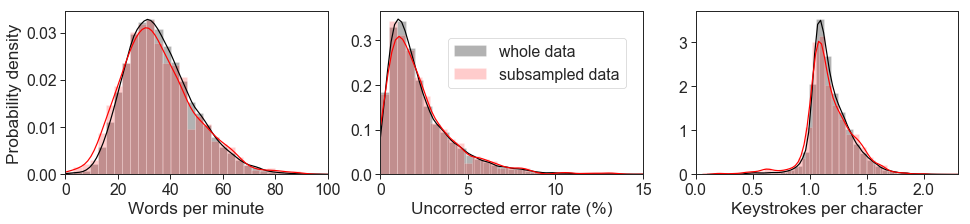

In [32]:
ROWS = 1
COLS = 3

fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(16,3), sharey=False)
sns.distplot(participants.WPM, ax=axs[0], color='black', hist_kws={"alpha":0.3})
sns.distplot(participants_US.WPM, ax=axs[0], color='red',  hist_kws={"alpha":0.2})
axs[0].set(ylabel="Probability density")
axs[0].set(xlabel='Words per minute')
axs[0].set(xlim=[0,100])

sns.distplot(participants.ERROR_RATE, ax=axs[1], color='black', hist_kws={"alpha":0.3}, label="whole data")
sns.distplot(participants_US.ERROR_RATE, ax=axs[1], color='red', hist_kws={"alpha":0.2},  label="subsampled data")
#axs[1].set(ylabel="Probability density")
axs[1].set(xlabel='Uncorrected error rate (%)')
axs[1].set(xlim=[0,15])

sns.distplot(participants.P_KSPC, ax=axs[2],  color='black',  hist_kws={"alpha":0.3})
sns.distplot(participants_US.P_KSPC, ax=axs[2],  color='red',  hist_kws={"alpha":0.2})
#axs[2].set(ylabel="Probability density")
axs[2].set(xlabel='Keystrokes per character')
axs[2].set(xlim=[0,2.3])

fig.legend(bbox_to_anchor=(0.55, 0.9))
plt.savefig('comp_wpm_all.png', bbox_inches='tight', dpi=300)


In [34]:
def categorize_ite(row):
    if row['ITE_SWYPE']==0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']==0:
        return 'norm'
    elif row['ITE_SWYPE']!=0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']==0:
        return 'swype'
    elif row['ITE_SWYPE']==0 and row['ITE_PREDICT']!=0 and row['ITE_AUTOCORR']==0:
        return 'pred'
    elif row['ITE_SWYPE']==0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']!=0:
        return 'auto'    
    elif row['ITE_SWYPE']!=0 and row['ITE_PREDICT']!=0 and row['ITE_AUTOCORR']==0:
        return 'swype,pred'
    elif row['ITE_SWYPE']==0 and row['ITE_PREDICT']!=0 and row['ITE_AUTOCORR']!=0:
        return 'pred,auto'
    elif row['ITE_SWYPE']!=0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']!=0:
        return 'swype,auto'
    else:
        return 'mix'
    
participants['ITE_CAT'] = participants.apply(categorize_ite, axis=1 )    
participants_US['ITE_CAT'] = participants_US.apply(categorize_ite, axis=1 )

### 4.1 Factors versus performance: group differences analysis 

In [36]:
from scipy.stats import mannwhitneyu, wilcoxon, kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols

import numpy as np
import math

In [37]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


def agjustp(pvalues, correction_type = "Bonferroni-Holm"):                
    """                                                                                                   
    consistent with R - print correct_pvalues_for_multiple_testing([0.0, 0.01, 0.029, 0.03, 0.031, 0.05, 0.069, 0.07, 0.071, 0.09, 0.1]) 
    """                                                                        
    pvalues = np.array(pvalues) 
    n = pvalues.shape[0]                                                                        
    new_pvalues = np.empty(n)
    if correction_type == "Bonferroni":                                                                   
        new_pvalues = n * pvalues
    elif correction_type == "Bonferroni-Holm":                                                            
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        for rank, vals in enumerate(values):                                                              
            pvalue, i = vals
            new_pvalues[i] = (n-rank) * pvalue                                                            
    elif correction_type == "Benjamini-Hochberg":                                                         
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        values.reverse()                                                                                  
        new_values = []
        for i, vals in enumerate(values):                                                                 
            rank = n - i
            pvalue, index = vals                                                                          
            new_values.append((n/rank) * pvalue)                                                          
        for i in xrange(0, int(n)-1):  
            if new_values[i] < new_values[i+1]:                                                           
                new_values[i+1] = new_values[i]                                                           
        for i, vals in enumerate(values):
            pvalue, index = vals
            new_pvalues[index] = new_values[i]                                                                                                                  
    return new_pvalues

In [38]:
# Substitute WMP with a quantity of interest. 
g1 = participants.WPM
g2 = participants_US.WPM

print('Kruskal-Wallis:', kruskal(g1, g2))
print('Mann-Whitney: ', mannwhitneyu(g1, g2).pvalue)
print('Cohen d value: ', cohend(g1, g2))

Kruskal-Wallis: KruskalResult(statistic=7.610712956333503, pvalue=0.005802253814311953)
Mann-Whitney:  0.002901137305311065
Cohen d value:  0.05414996781455689


### 4.1.1 Gender

In [39]:
# Change participants to participants_US to work with subsample.
g1 = participants[participants.GENDER=='female']['WPM'].values
g2 = participants[participants.GENDER=='male']['WPM'].values
print('Kruskal-Wallis:', kruskal(g1, g2))
print('Mann-Whitney witn Bonferrony correction: ', mannwhitneyu(g1, g2).pvalue)

print('Adjusted p-values:')
print(agjustp([mannwhitneyu(g1, g2).pvalue]))

print('Cohen d values: ')
print(cohend(g1, g2))

Kruskal-Wallis: KruskalResult(statistic=8.842675251474786, pvalue=0.002942674835912882)
Mann-Whitney witn Bonferrony correction:  0.0014713400595520755
Adjusted p-values:
[0.00147134]
Cohen d values: 
-0.003946908584668655


female   0.647
male     0.307
none     0.046
Name: GENDER, dtype: float64


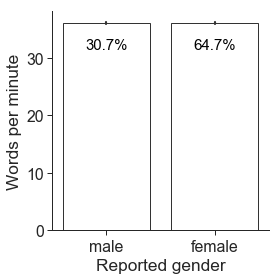

In [42]:
print(participants.GENDER.value_counts(normalize=True))
g = sns.catplot(x="GENDER", y="WPM", kind='bar', data=participants[participants.GENDER != 'none'], height=4, aspect=1, linewidth=1.0, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2");

# Get current axis on current figure
ax = plt.gca()
labels = ['30.7%', '64.7%', '4.6%']
# Iterate through the list of axes' patches
for i in range(0, len(ax.patches)):
    p = ax.patches[i]
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 5, '%s' % labels[i], 
            fontsize=15, color='black', ha='center', va='bottom')  
    
plt.xlabel("Reported gender")
plt.ylabel("Words per minute")
plt.savefig('gender_wpm.png', bbox_inches='tight', dpi=300)

#### 4.1.2 Age and time spent typing

In [50]:
# Change participants to participants_US to work with subsample.
g1 = participants_US[participants_US.AGE_CAT=='0-9']['WPM'].values
g2 = participants_US[participants_US.AGE_CAT=='10-19']['WPM'].values
g3 = participants_US[participants_US.AGE_CAT=='20-29']['WPM'].values
g4 = participants_US[participants_US.AGE_CAT=='30-39']['WPM'].values
g5 = participants_US[participants_US.AGE_CAT=='40-49']['WPM'].values
g6 = participants_US[participants_US.AGE_CAT=='50-59']['WPM'].values
g7 = participants_US[participants_US.AGE_CAT=='60-69']['WPM'].values

print('Kruskal-Wallis:', kruskal(g1, g2, g3, g4, g5, g6, g7))
n=7
pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g1, g4).pvalue,
mannwhitneyu(g1, g5).pvalue,
mannwhitneyu(g1, g6).pvalue,
mannwhitneyu(g1, g7).pvalue,
mannwhitneyu(g2, g3).pvalue,
mannwhitneyu(g2, g4).pvalue,
mannwhitneyu(g2, g5).pvalue,
mannwhitneyu(g2, g6).pvalue,
mannwhitneyu(g2, g7).pvalue,
mannwhitneyu(g3, g4).pvalue,
mannwhitneyu(g3, g5).pvalue,
mannwhitneyu(g3, g6).pvalue,
mannwhitneyu(g3, g7).pvalue,
mannwhitneyu(g4, g5).pvalue,
mannwhitneyu(g4, g6).pvalue,
mannwhitneyu(g4, g7).pvalue,
mannwhitneyu(g5, g6).pvalue,
mannwhitneyu(g5, g7).pvalue,
mannwhitneyu(g6, g7).pvalue
    ]
cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g1, g4),
    cohend(g1, g5),
    cohend(g1, g6),
    cohend(g1, g7),
    cohend(g2, g3),
    cohend(g2, g4),
    cohend(g2, g5),
    cohend(g2, g6),
    cohend(g2, g7),
    cohend(g3, g4),
    cohend(g3, g5),
    cohend(g3, g6),
    cohend(g3, g7),
    cohend(g4, g5),
    cohend(g4, g6),
    cohend(g4, g7),
    cohend(g5, g6), 
    cohend(g5, g7),
    cohend(g6, g7) 
]
print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)

Kruskal-Wallis: KruskalResult(statistic=210.6607662253282, pvalue=1.0184014514331619e-42)
Mann-Whitney p values:
[1.3245471923341846e-06, 6.032966201133771e-08, 8.531125364621036e-05, 0.04991261796368216, 0.3503232313846527, 0.29772249236394077, 0.06882067208321102, 1.0922351695238442e-06, 7.782449702236055e-15, 1.0979975151935265e-17, 2.290237238878703e-05, 6.293921204381226e-11, 5.04849583479329e-20, 5.954679074561209e-23, 1.2826093098176326e-06, 8.810856043701505e-07, 2.4381037270149205e-11, 0.0008606362294095066, 0.013298698062536671, 0.2158310661693919, 0.28695851330383493]
Adjusted p-values:
[1.45700191e-05 9.04944930e-07 7.67801283e-04 2.99475708e-01
 3.50323231e-01 5.95444985e-01 3.44103360e-01 1.41990572e-05
 1.40084095e-13 2.08619528e-16 2.29023724e-04 1.00702739e-09
 1.00969917e-18 1.25048261e-21 1.53913117e-05 1.23351985e-05
 4.14477634e-10 6.88508984e-03 9.30908864e-02 8.63324265e-01
 8.60875540e-01]
Cohen d values: 
[-0.8842293615576986, -1.0748846620397254, -0.7293041422

20-29   0.473
10-19   0.308
30-39   0.144
40-49   0.049
50-59   0.018
0-9     0.007
60-69   0.002
Name: AGE_CAT, dtype: float64


C:\Users\matti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\matti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\matti\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To reta

<Figure size 720x288 with 0 Axes>

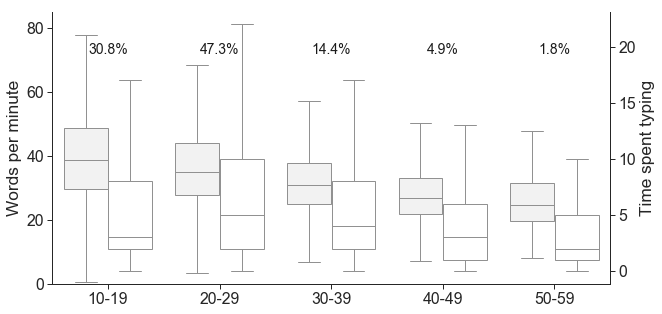

In [51]:
print(participants.AGE_CAT.value_counts(normalize=True))

order=['10-19', '20-29', '30-39', '40-49', '50-59']

plt.figure(figsize=(10,4))

plotdata1 = participants[['WPM', 'AGE_CAT']]
plotdata1['PLOT'] = 'WPM'

plotdata2 = participants[[ 'TIME_SPENT_TYPING','AGE_CAT']]
plotdata2['PLOT'] = 'TIME'

plotdata = pd.concat([plotdata1, plotdata2])

fig,ax1= plt.subplots(figsize=(10, 5))

ax1 = sns.boxplot(ax=ax1,x='AGE_CAT', y = 'WPM',  hue='PLOT', data=plotdata[participants.AGE_CAT.isin(['10-19', '20-29', '30-39', '40-49', '50-59'])], color='w', order=order, linewidth=1.0,showfliers=False )

ax2 = ax1.twinx()

sns.boxplot(ax=ax2,x='AGE_CAT', y = 'TIME_SPENT_TYPING',  hue='PLOT', data=plotdata[participants.AGE_CAT.isin(['10-19', '20-29', '30-39', '40-49', '50-59'])], color='w', order=order, linewidth=1.0,showfliers=False)

    
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
    
labels = [ '30.8%', '47.3%', '14.4%', '4.9%', '1.8%', ]
ax1.set_xticklabels(['10-19', '20-29', '30-39', '40-49', '50-59'])
# Iterate through the list of axes' patches

medians = participants[participants.AGE_CAT.isin(['10-19', '20-29', '30-39', '40-49', '50-59'])].groupby(['AGE_CAT'])['WPM'].median().values
#median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax1.get_xticklabels()):
    ax1.text(pos[tick], 72, labels[tick], 
            horizontalalignment='center', color='k',  fontsize=14)
    
ax1.set_ylim(0,85)
ax1.set_xlabel('')   
ax1.set_ylabel("Words per minute")   
ax2.set_ylabel("Time spent typing")  

# Hide the right and top spines
ax1.spines['top'].set_visible(False)

# Hide the right and top spines
ax2.spines['top'].set_visible(False)

# plt.savefig('age_wpm_tme_box.png', bbox_inches='tight', dpi=300)

#### 4.1.3 Native language

In [57]:
g1 = participants[participants.NATIVE_LANGUAGE=='en']['WPM'].values
g2 = participants[participants.NATIVE_LANGUAGE!='en']['WPM'].values
print(mannwhitneyu(g1, g2))
print('Cohen d', cohend(g1, g2))

MannwhitneyuResult(statistic=119271955.5, pvalue=1.2203917438995756e-242)
Cohen d 0.37565996438856075


#### 4.1.4 Typing course

In [58]:
g1 = participants[participants.HAS_TAKEN_TYPING_COURSE==1]['WPM'].values
g2 = participants[participants.HAS_TAKEN_TYPING_COURSE==0]['WPM'].values
print(mannwhitneyu(g1, g2))
print('Cohen d', cohend(g1, g2))

MannwhitneyuResult(statistic=145093327.5, pvalue=2.4614884078973866e-08)
Cohen d -0.05358499643286487


0   0.686
1   0.314
Name: HAS_TAKEN_TYPING_COURSE, dtype: float64


Text(11.175,0.5,'Words per minute')

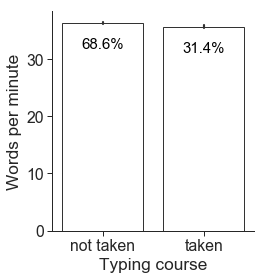

In [91]:
print(participants.HAS_TAKEN_TYPING_COURSE.value_counts(normalize=True))

g = sns.catplot(x="HAS_TAKEN_TYPING_COURSE", y="WPM", kind='bar', data=participants, height=4, aspect=1, linewidth=1.0, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2");

# Get current axis on current figure
ax = plt.gca()
labels = ['68.6%', '31.4%']
ax.set_xticklabels(['not taken', 'taken'])

# Iterate through the list of axes' patches
for i in range(0, len(ax.patches)):
    p = ax.patches[i]
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 5, '%s' % labels[i], 
            fontsize=15, color='black', ha='center', va='bottom')  
    
plt.xlabel("Typing course")
plt.ylabel("Words per minute")

#### 4.1.5 Number of fingers

In [62]:
g1 = participants[participants.NUM_FINGERS==1]['WPM'].values
g2 = participants[participants.NUM_FINGERS==2]['WPM'].values
print(mannwhitneyu(g1, g2))
print('Cohen d', cohend(g1, g2))

MannwhitneyuResult(statistic=47956046.0, pvalue=0.0)
Cohen d -0.6581920072923005


#### 4.1.6 Layout

In [68]:
g1 = participants[participants.LAYOUT=='qwerty']['WPM'].values
g2 = participants[participants.LAYOUT=='qwertz']['WPM'].values
g3 = participants[participants.LAYOUT=='azerty']['WPM'].values

pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g2, g3).pvalue
]

cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g2, g3)
]

print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)

Mann-Whitney p values:
[1.4667076538139923e-91, 1.1718626002378622e-86, 0.000586345570054743]
Adjusted p-values:
[4.40012296e-91 2.34372520e-86 5.86345570e-04]
Cohen d values: 
[0.4407086524567896, 0.5365084409453422, 0.10885182736574069]


qwerty   0.875
qwertz   0.057
azerty   0.036
other    0.033
Name: LAYOUT, dtype: float64


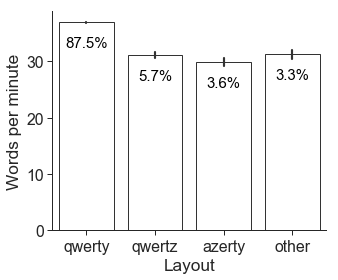

In [90]:
print(participants.LAYOUT.value_counts(normalize=True))

order = ['qwerty', 'qwertz','azerty','other']
g = sns.catplot(x="LAYOUT", y="WPM", kind='bar', data=participants, order = order,  height=4, aspect=1.2, linewidth=1.0, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2");
# Get current axis on current figure
ax = plt.gca()
labels = ['87.5%', '5.7%', '3.6%', '3.3%']
# Iterate through the list of axes' patches
for i in range(0, len(ax.patches)):
    p = ax.patches[i]
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 5, '%s' % labels[i], 
            fontsize=15, color='black', ha='center', va='bottom') 
plt.xlabel("Layout")
plt.ylabel("Words per minute")
plt.savefig('layout_wpm.png', bbox_inches='tight', dpi=300)

#### 4.1.7 Experience

In [70]:
g1 = participants[participants.TYPE_ENGLISH=='native']['WPM'].values
g2 = participants[participants.TYPE_ENGLISH=='always']['WPM'].values
g3 = participants[participants.TYPE_ENGLISH=='usually']['WPM'].values
g4 = participants[participants.TYPE_ENGLISH=='sometimes']['WPM'].values
g5 = participants[participants.TYPE_ENGLISH=='rarely']['WPM'].values
g6 = participants[participants.TYPE_ENGLISH=='never']['WPM'].values

print('Kruskal-Wallis:', kruskal(g1, g2, g3, g4, g5, g6))
n=6
pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g1, g4).pvalue,
mannwhitneyu(g1, g5).pvalue,
mannwhitneyu(g1, g6).pvalue,
mannwhitneyu(g2, g3).pvalue,
mannwhitneyu(g2, g4).pvalue,
mannwhitneyu(g2, g5).pvalue,
mannwhitneyu(g2, g6).pvalue,
mannwhitneyu(g3, g4).pvalue,
mannwhitneyu(g3, g5).pvalue,
mannwhitneyu(g3, g6).pvalue,
mannwhitneyu(g4, g5).pvalue,
mannwhitneyu(g4, g6).pvalue,
mannwhitneyu(g5, g6).pvalue
    ]
cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g1, g4),
    cohend(g1, g5),
    cohend(g1, g6),
    cohend(g2, g3),
    cohend(g2, g4),
    cohend(g2, g5),
    cohend(g2, g6),
    cohend(g3, g4),
    cohend(g3, g5),
    cohend(g3, g6),
    cohend(g4, g5),
    cohend(g4, g6),
    cohend(g5, g6) 
]

print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)

Kruskal-Wallis: KruskalResult(statistic=1364.9895016394355, pvalue=5.305944648590615e-293)
Mann-Whitney p values:
[3.154669173388852e-24, 6.993897479531812e-51, 2.0556501351007704e-200, 1.7162174011784084e-62, 1.9795075933976818e-38, 2.2978168147145605e-09, 1.9428890217961527e-99, 3.3224596238952436e-39, 1.8818932044624535e-30, 3.1479091800323835e-51, 9.511436937296164e-26, 6.41829533737689e-26, 0.017307227851767897, 2.4582027246272546e-11, 8.936684613120153e-07]
Adjusted p-values:
[1.57733459e-023 7.69328723e-050 3.08347520e-199 2.23108262e-061
 1.78155683e-037 6.89345044e-009 2.72004463e-098 3.32245962e-038
 1.50551456e-029 3.77749102e-050 5.70686216e-025 4.49280674e-025
 1.73072279e-002 9.83281090e-011 1.78733692e-006]
Cohen d values: 
[0.1341246323803484, 0.24808037767194885, 0.5569332648445152, 0.6099441960374954, 0.8972558213585397, 0.11747343943711586, 0.44612386144799027, 0.49472447040877665, 0.7891529575372634, 0.3582392209427396, 0.41938264423099564, 0.7462164798494487, 0.082

native      0.562
always      0.207
usually     0.119
sometimes   0.086
rarely      0.019
never       0.006
Name: TYPE_ENGLISH, dtype: float64


Text(11.175,0.5,'Words per minute')

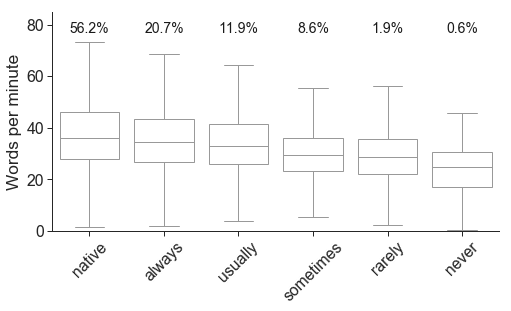

In [92]:
print(participants.TYPE_ENGLISH.value_counts(normalize=True))

order=['native', 'always', 'usually', 'sometimes', 'rarely', 'never']
g = sns.catplot(x="TYPE_ENGLISH", y="WPM", kind='box', data=participants, aspect=1.8, color='w', order=order, height=4, linewidth=1.0,
                showfliers=False
                #facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2"
               );
g.set_xticklabels(rotation=45)

# Get current axis on current figure
ax = plt.gca()
labels = ['56.2%', '20.7%', '11.9%', '8.6%', '1.9%', '0.6%']
# Iterate through the list of axes' patches
for i in range(0, len(ax.patches)):
    p = ax.patches[i]
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 5, '%s' % labels[i], 
            fontsize=15, color='black', ha='center', va='bottom') 

medians = participants.groupby(['TYPE_ENGLISH'])['WPM'].median().values
#median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 77, labels[tick], 
            horizontalalignment='center', color='k',  fontsize=14)

plt.ylim(0,85)
ax.set_xlabel('')
plt.ylabel("Words per minute")
#plt.savefig('exp_wpm_box.png', bbox_inches='tight', dpi=300)

#### 4.1.8 Browser

In [73]:
g1 = participants[participants.BROWSER=='Mobile Safari']['WPM'].values
g2 = participants[participants.BROWSER=='Chrome Mobile']['WPM'].values
g3 = participants[participants.BROWSER=='Samsung Internet']['WPM'].values

pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g2, g3).pvalue
]

cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g2, g3)
]

print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)

Mann-Whitney p values:
[0.0, 1.826620333124199e-75, 4.6155017531182784e-24]
Adjusted p-values:
[0.00000000e+00 3.65324067e-75 4.61550175e-24]
Cohen d values: 
[0.6278311217224073, 0.41873136521376747, -0.20728474832910468]


#### 4.1.9 Posture

In [76]:
g1 = participants_US[participants_US.HAND_FINGER=='both_hands;thumbs']['WPM'].values
g2 = participants_US[participants_US.HAND_FINGER=='right_hand;thumbs']['WPM'].values
g3 = participants_US[participants_US.HAND_FINGER=='left_hand;thumbs']['WPM'].values
g4 = participants_US[participants_US.HAND_FINGER=='both_hands;index_fingers']['WPM'].values
g5 = participants_US[participants_US.HAND_FINGER=='right_hand;index_fingers']['WPM'].values
g6 = participants_US[participants_US.HAND_FINGER=='left_hand;index_fingers']['WPM'].values


print('Kruskal-Wallis:', kruskal(g1, g2, g3, g4, g5, g6))
n=6
pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g1, g4).pvalue,
mannwhitneyu(g1, g5).pvalue,
mannwhitneyu(g1, g6).pvalue,
mannwhitneyu(g2, g3).pvalue,
mannwhitneyu(g2, g4).pvalue,
mannwhitneyu(g2, g5).pvalue,
mannwhitneyu(g2, g6).pvalue,
mannwhitneyu(g3, g4).pvalue,
mannwhitneyu(g3, g5).pvalue,
mannwhitneyu(g3, g6).pvalue,
mannwhitneyu(g4, g5).pvalue,
mannwhitneyu(g4, g6).pvalue,
mannwhitneyu(g5, g6).pvalue
    ]

cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g1, g4),
    cohend(g1, g5),
    cohend(g1, g6),
    cohend(g2, g3),
    cohend(g2, g4),
    cohend(g2, g5),
    cohend(g2, g6),
    cohend(g3, g4),
    cohend(g3, g5),
    cohend(g3, g6),
    cohend(g4, g5),
    cohend(g4, g6),
    cohend(g5, g6) 
]

print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)


Kruskal-Wallis: KruskalResult(statistic=127.14908563369772, pvalue=9.581235913659749e-26)
Mann-Whitney p values:
[2.3335295898319105e-10, 1.697963138140571e-05, 2.502738727634445e-07, 2.8613995679143124e-11, 3.0077909313720633e-07, 0.15705219475244936, 0.3423002933737008, 0.07653234728975289, 0.0005344370072493858, 0.28588683894412403, 0.475057752996344, 0.006481270693219463, 0.21587707068760487, 0.002875762393319181, 0.003186644002994641]
Adjusted p-values:
[3.26694143e-09 1.86775945e-04 3.25356035e-06 4.29209935e-10
 3.60934912e-06 7.85260974e-01 6.84600587e-01 4.59194084e-01
 5.34437007e-03 8.57660517e-01 4.75057753e-01 4.53688949e-02
 8.63508283e-01 2.58818615e-02 2.54931520e-02]
Cohen d values: 
[0.5758028881765612, 0.8193658145941232, 0.590679972504254, 0.7896266881369304, 1.340066669749474, 0.2917305700724191, 0.0229133713030694, 0.2569980176891647, 0.9102409528791789, -0.24665405344606456, -0.05353253131245072, 0.891035254677142, 0.2204630380812335, 0.8106520277305034, 0.849123

both_hands;thumbs           0.744
right_hand;thumbs           0.083
both_hands;other-nfingers   0.056
both_hands;index_fingers    0.034
right_hand;index_fingers    0.028
both_hands;other            0.015
left_hand;thumbs            0.012
right_hand;middle_fingers   0.007
both_hands;middle_fingers   0.006
right_hand;other            0.005
right_hand;other-nfingers   0.004
left_hand;index_fingers     0.003
left_hand;middle_fingers    0.001
left_hand;other-nfingers    0.001
left_hand;other             0.001
Name: HAND_FINGER, dtype: float64


Text(11.175,0.5,'Words per minute')

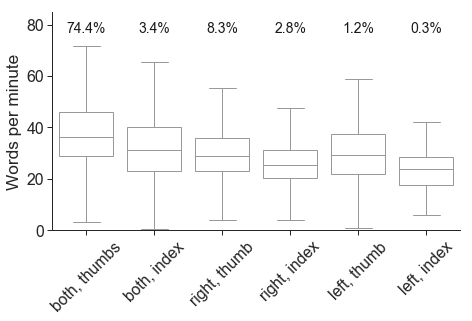

In [77]:
print(participants.HAND_FINGER.value_counts(normalize=True))

order = ['both_hands;thumbs', 'both_hands;index_fingers', 'right_hand;thumbs', 'right_hand;index_fingers', 'left_hand;thumbs', 'left_hand;index_fingers']

g = sns.catplot(x="HAND_FINGER", y="WPM", kind='box', 
                data=participants[participants.HAND_FINGER.isin(['both_hands;thumbs',
                                                                'right_hand;thumbs',
                                                                'left_hand;thumbs',
                                                                'both_hands;index_fingers',
                                                                'right_hand;index_fingers',
                                                                'left_hand;index_fingers',])], 
                order = order, aspect=1.8, height=4, linewidth=1.0, color='w',
                showfliers=False
               # , facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2"
               );
g.set_xticklabels(rotation=45)

# Get current axis on current figure
ax = plt.gca()
ax.set_xticklabels(['both, thumbs', 'both, index', 'right, thumb', 'right, index','left, thumb', 'left, index'])
labels = ['74.4%', '3.4%', '8.3%', '2.8%', '1.2%', '0.3%']
# Iterate through the list of axes' patches
for i in range(0, len(ax.patches)):
    p = ax.patches[i]
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 5, '%s' % labels[i], 
            fontsize=15, color='black', ha='center', va='bottom') 

medians = participants.groupby(['HAND_FINGER'])['WPM'].median().values
#median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 77, labels[tick], 
            horizontalalignment='center', color='k',  fontsize=14)

plt.ylim(0,85)
ax.set_xlabel("")
plt.ylabel("Words per minute")
#plt.savefig('posture_wpm_box.png', bbox_inches='tight', dpi=300)

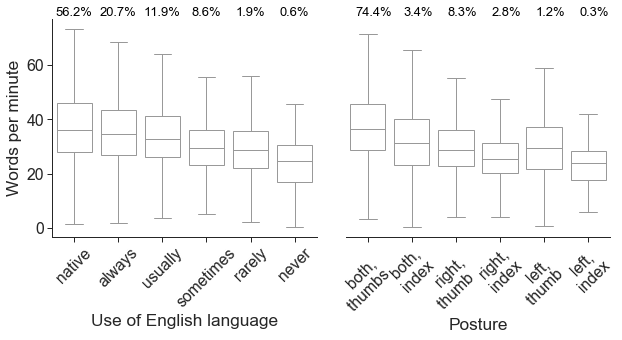

In [78]:
ROWS = 1
COLS = 2

fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4), sharey=True)
plt.subplots_adjust(wspace=0.11, hspace=0)
plt.xlim(0,80)

order=['native', 'always', 'usually', 'sometimes', 'rarely', 'never']
g=sns.boxplot(ax = axs[0], x="TYPE_ENGLISH", y="WPM", data=participants, color='w', linewidth=1.0,showfliers=False, order=order);
axs[0].set_xlabel("Use of English language")
axs[0].set_ylabel("Words per minute")
g.set_xticklabels(labels = g.get_xticklabels(), rotation=45)

order = ['both_hands;thumbs', 'both_hands;index_fingers', 'right_hand;thumbs', 'right_hand;index_fingers', 'left_hand;thumbs', 'left_hand;index_fingers']
g=sns.boxplot(ax = axs[1], x="HAND_FINGER", y="WPM", data=participants[participants.HAND_FINGER.isin(['both_hands;thumbs',
                                                                'right_hand;thumbs',
                                                                'left_hand;thumbs',
                                                                'both_hands;index_fingers',
                                                                'right_hand;index_fingers',
                                                                'left_hand;index_fingers',])], 
                color='w',  linewidth=1.0,showfliers=False, order=order)
axs[1].set_xticklabels(['both,\nthumbs   ', 'both,\nindex', 'right,\nthumb    ', 'right,\nindex','left,\nthumb   ', 'left,\nindex'])
axs[1].set_xlabel("Posture")
axs[1].set_ylabel("")
g.set_xticklabels(labels = g.get_xticklabels(), rotation=45)

# Hide the right and top spines
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].yaxis.set_ticks_position('none') 

labels1 = ['56.2%', '20.7%', '11.9%', '8.6%', '1.9%', '0.6%']
labels2 = ['74.4%', '3.4%', '8.3%', '2.8%', '1.2%', '0.3%']
# Iterate through the list of axes' patches
for i in range(0, len(labels1)):
    axs[0].text(i,77, '%s' % labels1[i], 
            fontsize=13, color='black', ha='center', va='bottom') 
for i in range(0, len(labels2)):
    axs[0].text(i+6.8,77, '%s' % labels2[i], 
            fontsize=13, color='black', ha='center', va='bottom') 

plt.savefig('double_box.png', bbox_inches='tight', dpi=300)

#### 4.1.10 OS

In [80]:
g1 = participants[participants.OS=='Android']['WPM'].values
g2 = participants[participants.OS=='iOS']['WPM'].values
g3 = participants[participants.OS=='Windows Phone']['WPM'].values

pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g2, g3).pvalue
]

cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g2, g3)
]

print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)

Mann-Whitney p values:
[0.0, 0.0944928031085921, 4.6906083742705656e-05]
Adjusted p-values:
[0.00000000e+00 9.44928031e-02 9.38121675e-05]
Cohen d values: 
[-0.6206905228076737, 0.25780123459046533, 0.8207130057232641]


#### 4.1.11 Intelligent text entry

In [81]:
participants['REP_SWYPE'] = participants.USING_FEATURES.apply(lambda x: 1 if x.find('swipe') != -1 else 0)

# Find participants whi have not reported using Swype, but ITE_SWYPE != 0. For them assignt ITE_PRED += ITE_SWYPE
reassign_indxs = participants[(participants['REP_SWYPE']==0) & (participants['ITE_SWYPE'] !=0)].index
participants.loc[reassign_indxs, 'ITE_PREDICT'] = participants.loc[reassign_indxs, 'ITE_PREDICT'] + participants.loc[reassign_indxs, 'ITE_SWYPE']
participants.loc[reassign_indxs, 'ITE_SWYPE'] = 0

In [83]:
g1 = participants_US[participants_US.ITE_CAT=='auto']['WPM'].values
g2 = participants_US[participants_US.ITE_CAT=='pred']['WPM'].values
g3 = participants_US[participants_US.ITE_CAT=='swype']['WPM'].values
g4 = participants_US[participants_US.ITE_CAT=='norm']['WPM'].values
g5 = participants_US[participants_US.ITE_CAT=='pred,auto']['WPM'].values
g6 = participants_US[participants_US.ITE_CAT=='swype,auto']['WPM'].values
g7 = participants_US[participants_US.ITE_CAT=='swype,pred']['WPM'].values
g8 = participants_US[participants_US.ITE_CAT=='mix']['WPM'].values


print('Kruskal-Wallis:', kruskal(g1, g2, g3, g4, g5, g6, g7, g8))
n=6
pvals = [
mannwhitneyu(g1, g2).pvalue,
mannwhitneyu(g1, g3).pvalue,
mannwhitneyu(g1, g4).pvalue,
mannwhitneyu(g1, g5).pvalue,
mannwhitneyu(g1, g6).pvalue,
mannwhitneyu(g1, g7).pvalue,
mannwhitneyu(g1, g8).pvalue,
mannwhitneyu(g2, g3).pvalue,
mannwhitneyu(g2, g4).pvalue,
mannwhitneyu(g2, g5).pvalue,
mannwhitneyu(g2, g6).pvalue,
mannwhitneyu(g2, g7).pvalue,
mannwhitneyu(g2, g8).pvalue,
mannwhitneyu(g3, g4).pvalue,
mannwhitneyu(g3, g5).pvalue,
mannwhitneyu(g3, g6).pvalue,
mannwhitneyu(g3, g7).pvalue,
mannwhitneyu(g3, g8).pvalue,
mannwhitneyu(g4, g5).pvalue,
mannwhitneyu(g4, g6).pvalue,
mannwhitneyu(g4, g7).pvalue,
mannwhitneyu(g4, g8).pvalue,
mannwhitneyu(g5, g6).pvalue,
mannwhitneyu(g5, g7).pvalue,
mannwhitneyu(g5, g8).pvalue,
mannwhitneyu(g6, g7).pvalue,
mannwhitneyu(g6, g8).pvalue,
mannwhitneyu(g7, g8).pvalue
    
    ]

cohenvals = [
    cohend(g1, g2), 
    cohend(g1, g3), 
    cohend(g1, g4),
    cohend(g1, g5),
    cohend(g1, g6),
    cohend(g1, g7),
    cohend(g1, g8),
    cohend(g2, g3),
    cohend(g2, g4),
    cohend(g2, g5),
    cohend(g2, g6),
    cohend(g2, g7),
    cohend(g2, g8),
    cohend(g3, g4),
    cohend(g3, g5),
    cohend(g3, g6),
    cohend(g3, g7),
    cohend(g3, g8),
    cohend(g4, g5),
    cohend(g4, g6),
    cohend(g4, g7),
    cohend(g4, g8),
    cohend(g5, g6),
    cohend(g5, g7),
    cohend(g5, g8),
    cohend(g6, g7),
    cohend(g6, g8),
    cohend(g7, g8),
]

print('Mann-Whitney p values:')
print(pvals)

print('Adjusted p-values:')
print(agjustp(pvals))

print('Cohen d values: ')
print(cohenvals)


Kruskal-Wallis: KruskalResult(statistic=72.3981592561513, pvalue=4.833781361852853e-13)
Mann-Whitney p values:
[9.485087592659884e-09, 0.1158023672974291, 0.01907882850921109, 1.555663915914736e-05, 0.007075080582618396, 1.596756547415245e-05, 4.070178234003247e-13, 0.028328545776975255, 0.000586114932279025, 6.209664509633924e-05, 0.00031933445777407364, 0.2320992688236883, 0.06165224715022806, 0.4770140717135626, 0.4272086607099399, 0.497970672352434, 0.1013857314107835, 0.08435519204536146, 0.29952905407821917, 0.3624215016052815, 0.019616537321032874, 0.0019922530315967194, 0.49796506268326085, 0.00924088780792037, 4.157225672653342e-06, 0.03955608683373478, 0.009628150824552408, 0.3793392828334705]
Adjusted p-values:
[2.56097365e-07 1.04222131e+00 3.05261256e-01 3.88915979e-04
 1.34426531e-01 3.83221571e-04 1.13964991e-11 3.96599641e-01
 1.23084136e-02 1.42822284e-03 7.02535807e-03 1.85679415e+00
 7.39826966e-01 1.43104222e+00 1.70883464e+00 4.97970672e-01
 1.01385731e+00 9.279071

pred,auto    0.315
mix          0.238
auto         0.149
norm         0.139
swype,pred   0.066
pred         0.053
swype,auto   0.020
swype        0.019
Name: ITE_CAT, dtype: float64


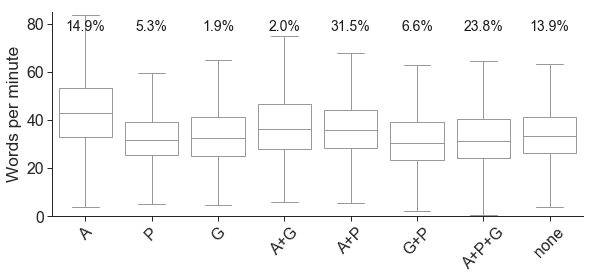

In [84]:
print(participants.ITE_CAT.value_counts(normalize=True))

order = [ 'auto','pred','swype','swype,auto','pred,auto', 'swype,pred',  'mix', 'norm'] 

#g = sns.catplot(x="ITE_CAT", y="WPM", kind='bar', data=participants, order=order,aspect=2.2, height=4, linewidth=1.0, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2");
g = sns.catplot(x="ITE_CAT", y="WPM", kind='box', data=participants, order=order,aspect=2.2, height=3.8, linewidth=1.0, color='white', showfliers=False);
g.set_xticklabels(rotation=45)


# Get current axis on current figure
ax = plt.gca()
ax.set_xticklabels(['A', 'P','G','A+G', 'A+P','G+P','A+P+G', 'none'])
labels = ['14.9%', '5.3%', '1.9%','2.0%', '31.5%', '6.6%', '23.8%', '13.9%']
# Iterate through the list of axes' patches
for i in range(0, len(ax.patches)):
    p = ax.patches[i]
    ax.text(p.get_x() + p.get_width()/2., p.get_height() - 5, '%s' % labels[i], 
            fontsize=15, color='black', ha='center', va='bottom') 
    

medians = participants.groupby(['ITE_CAT'])['WPM'].median().values
#median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 77, labels[tick], 
            horizontalalignment='center', color='k',  fontsize=14)

plt.ylim(0,85)
#plt.xlabel("ITE")
ax.set_xlabel('')
plt.ylabel("Words per minute")
#plt.savefig('ite_wpm_box.png', bbox_inches='tight', dpi=300)

## 5. ITE, detailed

count   26335.000
mean       34.930
std        12.570
min         0.019
25%        26.111
50%        33.433
75%        42.222
max       154.257
Name: WPM, dtype: float64
count   26335.000
mean        0.096
std         0.124
min         0.004
25%         0.019
50%         0.049
75%         0.124
max         0.995
Name: ITE_PREDICT, dtype: float64


C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


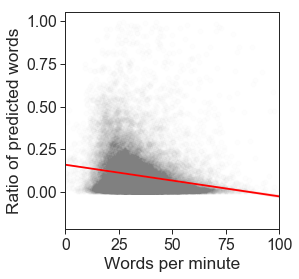

In [86]:
mask = (participants.ITE_PREDICT > 0) & (participants.ITE_PREDICT < 1)
print(participants[mask].WPM.describe())
print(participants[mask].ITE_PREDICT.describe())
sns.regplot(x=participants[mask].WPM, y=participants[mask].ITE_PREDICT, data=participants[mask], order=1, line_kws={"color":"red"}, scatter_kws={"alpha":0.01, "color":"grey"})
plt.ylabel("Ratio of predicted words")
plt.xlabel("Words per minute")
plt.xlim([0,100])
plt.axes().set_aspect(80)
#plt.savefig('ite1.png', bbox_inches='tight', dpi=300)

count   27022.000
mean       37.078
std        13.378
min         0.019
25%        27.417
50%        35.484
75%        45.310
max       154.257
Name: WPM, dtype: float64
count   27022.000
mean        0.084
std         0.074
min         0.004
25%         0.030
50%         0.063
75%         0.117
max         0.913
Name: ITE_AUTOCORR, dtype: float64


C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


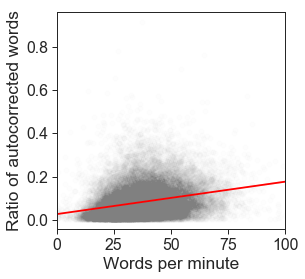

In [87]:
mask = (participants.ITE_AUTOCORR > 0) & (participants.ITE_AUTOCORR < 1)
print(participants[mask].WPM.describe())
print(participants[mask].ITE_AUTOCORR.describe())
sns.regplot(x=participants[mask].WPM, y=participants[mask].ITE_AUTOCORR, data=participants[mask], order=1, line_kws={"color":"red"}, scatter_kws={"alpha":0.01, "color":"grey"})
plt.ylabel("Ratio of autocorrected words")
plt.xlabel("Words per minute")
plt.xlim([0,100])
plt.axes().set_aspect(95)
#plt.savefig('ite2.png', bbox_inches='tight', dpi=300)

count   1434.000
mean      29.892
std       12.161
min        0.248
25%       21.440
50%       28.526
75%       35.902
max      102.711
Name: WPM, dtype: float64
count   1434.000
mean       0.222
std        0.324
min        0.004
25%        0.015
50%        0.042
75%        0.256
max        0.998
Name: ITE_SWYPE, dtype: float64


(0, 100)

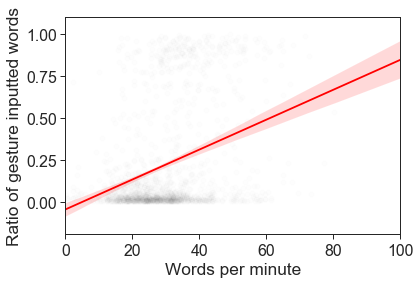

In [88]:
mask = (participants.ITE_SWYPE > 0) & (participants.ITE_SWYPE < 1)
print(participants[mask].WPM.describe())
print(participants[mask].ITE_SWYPE.describe())
sns.regplot(x=participants[mask].WPM, y=participants[mask].ITE_SWYPE, data=participants[mask], order=1, line_kws={"color":"red"}, scatter_kws={"alpha":0.01, "color":"grey"})
plt.ylabel("Ratio of gesture inputted words")
plt.xlabel("Words per minute")
plt.xlim([0,100])
#plt.savefig('ite3.png', bbox_inches='tight')